In [ ]:
import os
import visualize
import subprocess
import sys
subprocess.check_call([ sys.executable, "-m", "pip", "install", "gym" ])
subprocess.check_call([ sys.executable, "-m", "pip", "install", "neat-python" ])
import gym
from gym import wrappers
import neat
import multiprocessing
import pickle

import numpy as np
example_directory = os.getcwd()
os.chdir('../..')
import wann_genome
import wann_reproduce
import parallel
os.chdir(example_directory)

# Cartpole with Weight Agnostic Neural Networks

In [3]:
wVals = np.array((-2,-1,-0.5,0.5,1,2))
nVals = len(wVals)
nReps = 3

# Custom activation functions
def step_activation(z):
    return 1.0 * (z > 0.0)

def cos_activation(z):
    return np.cos(np.pi * z)

def inv_activation(z):
    return -z

* Parallel evaluation
* Test the N.N. with all the weights [-2,-1,-0.5,0.5,1,2] (multiple rollouts)
* Save the mean fitness of all the rollouts
* Save max fitness of all the rollouts

In [4]:
class Worker:
    def __init__(self, genome, config):
        self.genome = genome
        self.config = config

    def work(self):

        self.env = gym.make("CartPole-v1")
        
        reward = np.empty(nVals)
        
        for iVal in range(nVals):

            # Set single-shared weight values
            for connection in self.genome.connections.values():
                connection.weight = wVals[ iVal ]

            net = neat.nn.FeedForwardNetwork.create(self.genome, self.config)
            
            state = self.env.reset()

            done = False
            total_reward = 0.0

            while not done:

                action = net.activate(state)[0]
                if action >= 0.5:
                    action = 1
                else:
                    action = 0

                state, score, done, info = self.env.step(action)

                # Penalty if the cart moves too much from the center
                if state[0] > 0.5 or state[0] < -0.5:
                    total_reward -= score
                else:
                    total_reward += score

                if done:
                    reward[iVal] = total_reward

        self.env.close()
        
        # Mean performance over all weight values
        self.genome.fitness = np.mean(reward)
        
        # Max performance of the single best weight value
        self.genome.fitMax = np.max(reward)
        
        # Return the whole genome -> look in the parallel.py
        return self.genome


def eval_genomes_parallel(genome, config):
    worker = Worker(genome, config)
    return worker.work()



* Load the configuration file for the NEAT algorithm
* Pass the custom WannGenome and WannReproduction to the NEAT config
* Add step and cos activation functions
* Initialize the population
* Add parallel evaluation
* Add NEAT reporter and statistics

In [5]:

config = neat.Config(wann_genome.WannGenome, wann_reproduce.WannReproduction,
                     neat.DefaultSpeciesSet, neat.DefaultStagnation,
                     'config_file')

config.genome_config.add_activation('step', step_activation)
config.genome_config.add_activation('cos', cos_activation)
config.genome_config.add_activation('inverse', inv_activation)


p = neat.Population(config)

pe = parallel.ParallelEvaluator(multiprocessing.cpu_count(), eval_genomes_parallel)

p.add_reporter(neat.StdOutReporter(True))
stats = neat.StatisticsReporter()
p.add_reporter(stats)
p.add_reporter(neat.Checkpointer(100))


* Run the WANN algorithm

In [6]:
winner = p.run(pe.evaluate)


 ****** Running generation 0 ****** 

Population's average fitness: 20.08500 stdev: 16.86638
Best fitness: 86.66667 - size: (1, 4) - species 1 - id 124
Average adjusted fitness: 0.146
Mean genetic distance 1.162, standard deviation 0.267
Population of 200 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   200     86.7    0.146     0
Total extinctions: 0
Generation time: 0.404 sec

 ****** Running generation 1 ****** 

Population's average fitness: 35.64583 stdev: 33.29024
Best fitness: 254.33333 - size: (2, 5) - species 1 - id 306
Average adjusted fitness: 0.353
Mean genetic distance 1.313, standard deviation 0.309
Population of 200 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   200    254.3    0.353     0
Total extinctions: 0
Generation time: 0.491 sec (0.447 average)

 ****** Running generation 2 ****** 

Population's average fitness: 50.20000

Population's average fitness: 58.96667 stdev: 98.94677
Best fitness: 397.16667 - size: (2, 6) - species 1 - id 3457
Average adjusted fitness: 0.358
Mean genetic distance 1.279, standard deviation 0.526
Population of 200 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   17   140    397.2    0.362     0
     2    5    60    255.3    0.354     2
Total extinctions: 0
Generation time: 0.892 sec (0.943 average)

 ****** Running generation 18 ****** 

Population's average fitness: 64.34667 stdev: 97.73329
Best fitness: 380.83333 - size: (2, 8) - species 1 - id 3706
Average adjusted fitness: 0.335
Mean genetic distance 1.330, standard deviation 0.485
Population of 200 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   18   136    380.8    0.359     1
     2    6    64    258.0    0.310     0
Total extinctions: 0
Generation time: 0.806 sec (0.945 average)

 ****** Run

* Pickle the winner genome object.
* Display the genome information
* Plot and save the fitness stats


Best genome:
Key: 4638
Fitness: 500.0
Nodes:
	0 WannNodeGene(key=0, bias=0.5194819365555836, response=1.0, activation=relu, aggregation=sum)
	67 WannNodeGene(key=67, bias=-0.4883561402255304, response=1.0, activation=cos, aggregation=sum)
	827 WannNodeGene(key=827, bias=-1.285862756255948, response=1.0, activation=relu, aggregation=sum)
	841 WannNodeGene(key=841, bias=-0.9319224102112637, response=1.0, activation=relu, aggregation=sum)
	943 WannNodeGene(key=943, bias=-0.5949071293727832, response=1.0, activation=relu, aggregation=sum)
Connections:
	WannConnectionGene(key=(-4, 0), weight=2.0, enabled=True)
	WannConnectionGene(key=(-4, 67), weight=2.0, enabled=True)
	WannConnectionGene(key=(-3, 0), weight=2.0, enabled=False)
	WannConnectionGene(key=(-3, 67), weight=2.0, enabled=True)
	WannConnectionGene(key=(-3, 827), weight=2.0, enabled=True)
	WannConnectionGene(key=(-2, 0), weight=2.0, enabled=True)
	WannConnectionGene(key=(-2, 67), weight=2.0, enabled=True)
	WannConnectionGene(key=(-

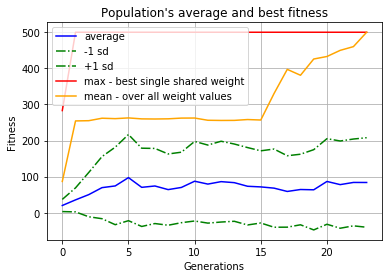

In [7]:
with open('winner', 'wb') as f:
    pickle.dump(winner, f)
    
print('\nBest genome:\n{!s}'.format(winner))
visualize.plot_stats(stats, ylog=False, view=True, filename='cartpole-fitness')

# TEST & RENDER THE WINNER
* Load the best genome object from a file.
* Display the winner genome information (nodes, connections etc.)
* Display the architecture of the winner genome


Best genome:
Key: 4638
Fitness: 500.0
Nodes:
	0 WannNodeGene(key=0, bias=0.5194819365555836, response=1.0, activation=relu, aggregation=sum)
	67 WannNodeGene(key=67, bias=-0.4883561402255304, response=1.0, activation=cos, aggregation=sum)
	827 WannNodeGene(key=827, bias=-1.285862756255948, response=1.0, activation=relu, aggregation=sum)
	841 WannNodeGene(key=841, bias=-0.9319224102112637, response=1.0, activation=relu, aggregation=sum)
	943 WannNodeGene(key=943, bias=-0.5949071293727832, response=1.0, activation=relu, aggregation=sum)
Connections:
	WannConnectionGene(key=(-4, 0), weight=2.0, enabled=True)
	WannConnectionGene(key=(-4, 67), weight=2.0, enabled=True)
	WannConnectionGene(key=(-3, 0), weight=2.0, enabled=False)
	WannConnectionGene(key=(-3, 67), weight=2.0, enabled=True)
	WannConnectionGene(key=(-3, 827), weight=2.0, enabled=True)
	WannConnectionGene(key=(-2, 0), weight=2.0, enabled=True)
	WannConnectionGene(key=(-2, 67), weight=2.0, enabled=True)
	WannConnectionGene(key=(-

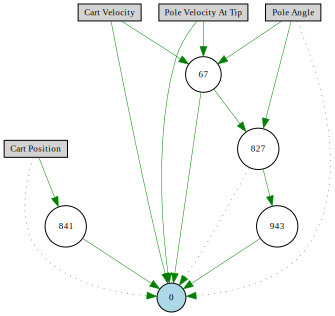

In [10]:
winner = None
with open('winner', 'rb') as f:
    winner = pickle.load(f)
    

    
print('\nBest genome:\n{!s}'.format(winner))
node_names = {-1:'Cart Position', -2: 'Cart Velocity', -3: 'Pole Angle', -4:'Pole Velocity At Tip'}
visualize.draw_net(config, winner, True, node_names=node_names)

* Use the winner genome object to create a new neural network
* Test the N.N. with all the weights [-2,-1,-0.5,0.5,1,2]
* Save each rollout fitness 
* Save each rollout as mp4 video


In [11]:
fitness_per_weight = {}
def test_winner(weight_values):
    
    for iVal in range(len(weight_values)):
        
        env = gym.make("CartPole-v1")
        
        # Monitor the winning genome and save it to a .mp4 format
        env = wrappers.Monitor(env, "./gym-results/" + str(iVal))
        
        for connection in winner.connections.values():
            connection.weight = weight_values[ iVal ]

        net = neat.nn.FeedForwardNetwork.create(winner, config)

        total_reward = 0.0
        state = env.reset()

        done = False
        total_reward = 0.0

        while not done:

            #env.render()
            
            # action can only can be 0 or 1
            action = net.activate(state)[0]
            if action >= 0.5:
                action = 1
            else:
                action = 0

            state, score, done, info = env.step(action)

            # By default the position (state[0]) is min -2.4 and max 2.4.. this doesn't prevent the cart from moving from the center.. https://github.com/openai/gym/wiki/CartPole-v0
            # New min is -0.5 max is 0.5
            if state[0] > 0.5 or state[0] < -0.5:
                total_reward -= score
            else:
                total_reward += score

            if done:
                env.close()
                fitness_per_weight.update({str(weight_values[ iVal ]): total_reward})

test_winner(np.array((-2,-1,-0.5,0.5,1,2)))

* Display the rollout videos

NOTE: Run the cell again if the videos are not playing

In [2]:
import io
import base64
from IPython.display import HTML

neg_2 = io.open('./gym-results/0/openaigym.video.0.24288.video000000.mp4', 'r+b').read()
neg_1 = io.open('./gym-results/1/openaigym.video.1.24288.video000000.mp4', 'r+b').read()
neg_0_5 = io.open('./gym-results/2/openaigym.video.2.24288.video000000.mp4', 'r+b').read()

pos_0_5 = io.open('./gym-results/3/openaigym.video.3.24288.video000000.mp4', 'r+b').read()
pos_1 = io.open('./gym-results/4/openaigym.video.4.24288.video000000.mp4', 'r+b').read()
pos_2 = io.open('./gym-results/5/openaigym.video.5.24288.video000000.mp4', 'r+b').read()
encoded_n2 = base64.b64encode(neg_2)
encoded_n1 = base64.b64encode(neg_1)
encoded_n_0_5 = base64.b64encode(neg_0_5)
encoded_p_0_5 = base64.b64encode(pos_0_5)
encoded_p1 = base64.b64encode(pos_1)
encoded_p2 = base64.b64encode(pos_2)

HTML('''       
<table style="width:100%">
  <tr>
    <th style="text-align:center">w = -2.0</th>
    <th style="text-align:center">w = -1.0</th>
    <th style="text-align:center">w = -0.5</th>
  </tr>
  <tr>
    <td>
        <video width="300" height="auto" alt="test" controls autoplay loop>
            <source src="data:neg_2/mp4;base64,{0}" type="video/mp4" />
        </video>
    </td>
    <td>
        <video width="300" height="auto" alt="test" controls autoplay loop>
            <source src="data:neg_1/mp4;base64,{1}" type="video/mp4" />
        </video>
    </td>
    <td>
        <video width="300" height="auto" alt="test" controls autoplay loop>
            <source src="data:neg_0_5/mp4;base64,{2}" type="video/mp4" />
        </video>
    </td>
  </tr>
  <tr>
    <th style="text-align:center">w = +2.0</th>
    <th style="text-align:center">w = +1.0</th>
    <th style="text-align:center">w = +0.5</th>
  </tr>
  <tr>
  <tr>
    <td>
        <video width="300" height="auto" alt="test" controls autoplay loop>
            <source src="data:pos_0_5/mp4;base64,{3}" type="video/mp4" />
        </video>
    </td>
    <td>
        <video width="300" height="auto" alt="test" controls autoplay loop>
            <source src="data:pos_1/mp4;base64,{4}" type="video/mp4" />
        </video>
    </td>
    <td>
        <video width="300" height="auto" alt="test" controls autoplay loop>
            <source src="data:pos_2/mp4;base64,{5}" type="video/mp4" />
        </video>
    </td>
  </tr>
</table>
     '''.format(encoded_n2.decode('ascii'), encoded_n1.decode('ascii'), encoded_n_0_5.decode('ascii'),
               encoded_p_0_5.decode('ascii'), encoded_p1.decode('ascii'),encoded_p2.decode('ascii')))

w = -2.0,w = -1.0,w = -0.5


# Final Neural Network Topology with fixed weight values

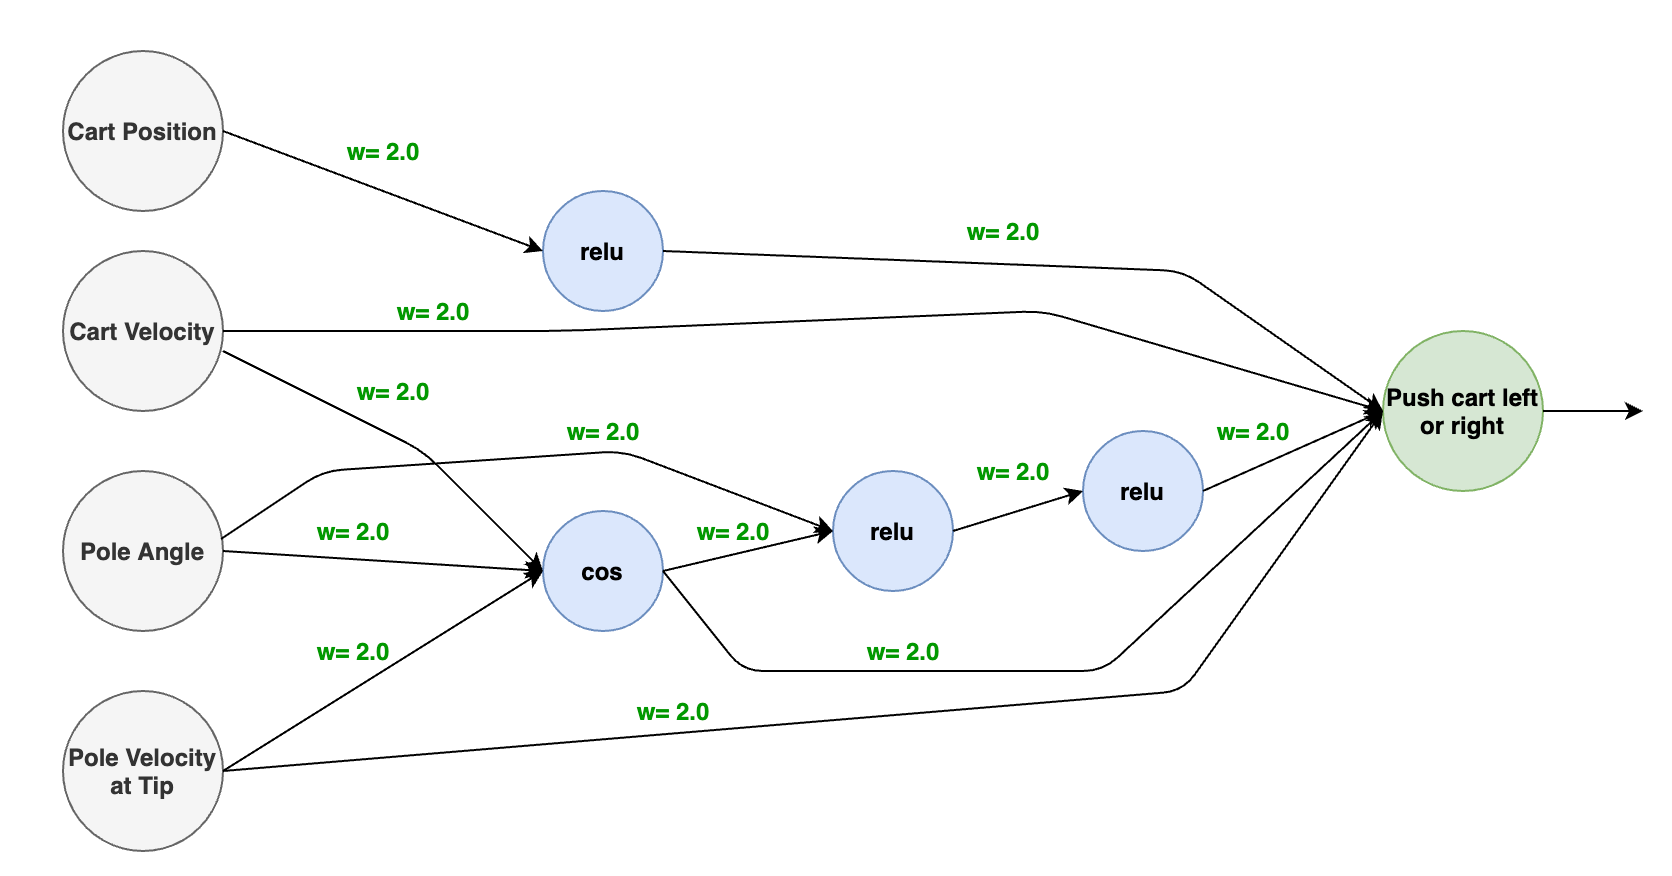

In [18]:
from IPython.display import Image
Image("net.png")